# Sharp wave-ripple network model using cell models fitted to electrophysiological recordings

The synaptic time constants and weights still need to be tuned. Stay tuned...

## Imports and basic declarations

In [1]:
#!/usr/bin/python
# -*- coding: utf8 -*-

from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import sys
import random as pyrandom

# base directory of the project
SWBasePath = os.path.sep.join(os.path.abspath('__file__').split(os.path.sep)[:-2])
# add the 'scripts' directory to the path. now we can import the modules in there
sys.path.insert(0, os.path.sep.join([SWBasePath, 'scripts']))

from detect_oscillations import *
from plots import *

set_device('cpp_standalone')

In [2]:
fIn = 'wmxR_asym.txt'

figures_folder = os.path.sep.join([SWBasePath, 'scripts', 'jupyter_figures'])
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

NE = 4000
NI = 1000

# sparseness
eps_pyr = 0.16
eps_bas = 0.4

### Pyramidal cell parameters

In [3]:
# parameters for pyr cells
pyr_params = np.genfromtxt('pyr_params.param')

z           = 1*nS
gL_Pyr      = pyr_params[0]     * uS
tauMem_Pyr  = pyr_params[1]     * ms
Cm_Pyr      = tauMem_Pyr * gL_Pyr
Vrest_Pyr   = pyr_params[2]     * mV
reset_Pyr   = pyr_params[3]     * mV
theta_Pyr   = pyr_params[4]     * mV
tref_Pyr    = pyr_params[5]     * ms

# Adaptation parameters for pyr cells
a_Pyr       = pyr_params[6] * nS              # nS    Subthreshold adaptation conductance
b_Pyr       = pyr_params[7] * nA              # nA    Spike-triggered adaptation
delta_T_Pyr = pyr_params[8] * mV              # Slope factor
tau_w_Pyr   = pyr_params[9] * ms              # Adaptation time constant
v_spike_Pyr = theta_Pyr + 10 * delta_T_Pyr

### Basket cell parameters

In [4]:
# parameters for bas cells
bas_params = np.genfromtxt('bas_params.param')

gL_Bas      = bas_params[0] * uS
tauMem_Bas  = bas_params[1] * ms
Cm_Bas      = tauMem_Bas * gL_Bas
Vrest_Bas   = bas_params[2] * mV
reset_Bas   = bas_params[3] * mV
theta_Bas   = bas_params[4] * mV
tref_Bas    = bas_params[5] * ms

# Adaptation parameters for pyr cells
a_Bas       = bas_params[6] * nS              # nS    Subthreshold adaptation conductance
b_Bas       = bas_params[7] * nA              # nA    Spike-triggered adaptation
delta_T_Bas = bas_params[8] * mV              # Slope factor
tau_w_Bas   = bas_params[9] * ms              # Adaptation time constant
v_spike_Bas = theta_Bas + 10 * delta_T_Bas

### Synaptic parameters

In [5]:
# synaptic weights
J_PyrInh = 0.04 #7.75 #0.04 #0.125  # 0.15
J_BasExc = 32. #0.95 #32. #4.5 #5.2083  # 4.5  # 5.2083
J_BasInh = 10. #6.2 #10. #8. #10. #0.95  # 0.25  # 0.15

# Synaptic reversal potentials
E_Exc = 0.0*mV
E_Inh = -70.0*mV

# Synaptic delays
delay_PyrExc = 4.2*ms
delay_PyrInh = 1.1*ms
delay_BasExc = 0.5*ms# * 0.67
delay_BasInh = 0.6*ms# * 0.67
# delay_PyrExc = 3.0*ms
# delay_PyrInh = 1.5*ms * 1.3
# delay_BasExc = 3.0*ms
# delay_BasInh = 1.5*ms * 0.6 #* 0.55

# Synaptic decays -- values the same as for the simple exponential synapse
# PyrExc_decay = 10.0*ms
# PyrInh_decay = 3.0*ms * 1.1
# BasExc_decay = 3.0*ms
# BasInh_decay = 1.5*ms * 0.67

# Synaptic decays -- two parameter sets from somewhere
PyrExc_decay = 4.8  * ms # unified cikk
PyrInh_decay = 3.3  * ms
BasExc_decay = 2.0  * ms # unified cikk
BasInh_decay = 1.2  * ms

# PyrExc_decay = 2.5 * ms
# PyrInh_decay = 4.0 * ms
# BasExc_decay = 2.0 * ms
# BasInh_decay = 2.5 * ms

# Synaptic rises -- two parameter sets from somewhere
PyrExc_rise = 0.6  * ms # unified cikk
PyrInh_rise = 0.35 * ms
BasExc_rise = 0.35 * ms # unified cikk
BasInh_rise = 0.3  * ms

# PyrExc_rise = 0.5  * ms
# PyrInh_rise = 0.3  * ms
# BasExc_rise = 0.35 * ms
# BasInh_rise = 0.4  * ms


# Normalization factors -- they normalize the peak of the curve to 1
invpeak_PyrExc = (PyrExc_decay / PyrExc_rise) ** (PyrExc_rise / (PyrExc_decay - PyrExc_rise))

invpeak_PyrInh = (PyrInh_decay / PyrInh_rise) ** (PyrInh_rise / (PyrInh_decay - PyrInh_rise))

invpeak_BasExc = (BasExc_decay / BasExc_rise) ** (BasExc_rise / (BasExc_decay - BasExc_rise))

invpeak_BasInh = (BasInh_decay / BasInh_rise) ** (BasInh_rise / (BasInh_decay - BasInh_rise))



# input parameters
p_rate_mf = 25. * Hz #5. * Hz #25.*Hz
J_PyrMF = 30. #45.5 #18.

In [6]:
print 'J_PyrInh:', J_PyrInh
print 'J_BasExc:', J_BasExc
print 'J_BasInh:', J_BasInh

J_PyrInh: 0.04
J_BasExc: 32.0
J_BasInh: 10.0


### Cell model definitions

In [7]:
eqs_adexp = '''
dvm/dt = (-gL_Pyr*(vm-Vrest_Pyr) + gL_Pyr*delta_T_Pyr*exp((vm- theta_Pyr)/delta_T_Pyr)-w - (g_ampa*z*(vm-E_Exc) + g_gaba*z*(vm-E_Inh)))/Cm_Pyr : volt (unless refractory)
dw/dt = (a_Pyr*(vm- Vrest_Pyr )-w)/tau_w_Pyr : amp
dg_ampa/dt = (invpeak_PyrExc * x_ampa - g_ampa) / PyrExc_rise : 1
dx_ampa/dt = -x_ampa / PyrExc_decay : 1
dg_gaba/dt = (invpeak_PyrInh * x_gaba - g_gaba) / PyrInh_rise : 1
dx_gaba/dt = -x_gaba/PyrInh_decay : 1
'''

reset_pyr = '''
vm = reset_Pyr
w += b_Pyr
'''

eqs_bas = '''
dvm/dt = (-gL_Bas*(vm-Vrest_Bas) + gL_Bas*delta_T_Bas*exp((vm- theta_Bas)/delta_T_Bas)-w - (g_ampa*z*(vm-E_Exc) + g_gaba*z*(vm-E_Inh)))/Cm_Bas : volt (unless refractory)
dw/dt = (a_Bas*(vm- Vrest_Bas )-w)/tau_w_Bas : amp
dg_ampa/dt = (invpeak_BasExc * x_ampa - g_ampa) / BasExc_rise : 1
dx_ampa/dt = -x_ampa/BasExc_decay : 1
dg_gaba/dt = (invpeak_BasInh * x_gaba - g_gaba) / BasInh_rise : 1
dx_gaba/dt = -x_gaba/BasInh_decay : 1
'''

reset_bas = '''
vm = reset_Bas
w += b_Bas
'''

## Creating and initializing populations

In [8]:
PE = NeuronGroup(NE, model=eqs_adexp, threshold='vm > v_spike_Pyr', reset=reset_pyr, refractory=tref_Pyr, method='exponential_euler')
PI = NeuronGroup(NI, model=eqs_bas,   threshold='vm > v_spike_Bas', reset=reset_bas, refractory=tref_Bas, method='exponential_euler')

PE.vm = Vrest_Pyr
PE.g_ampa = 0
PE.g_gaba = 0

PI.vm  = Vrest_Bas
PI.g_ampa = 0
PI.g_gaba = 0

MF = PoissonGroup(NE, p_rate_mf)

## Connecting the network

In [9]:
print 'Connecting the network'

# Poisson to Pyr
Cext = Synapses(MF, PE, on_pre='x_ampa += J_PyrMF')#, method='rk4')
Cext.connect(j='i')

# Pyr - Pyr
fName = os.path.join(SWBasePath, 'files', fIn)
Wee = np.genfromtxt(fName) * 1.e9 * 5.0
np.fill_diagonal(Wee, 0)
gc.collect()

Cee = Synapses(PE, PE, 'w_exc : 1', on_pre='x_ampa += w_exc')#, method='rk4')
Cee.connect()
        
Cee.w_exc = Wee.flatten()
Cee.delay = delay_PyrExc

del Wee

# Pyr - Bas
Cei = Synapses(PE, PI, on_pre='x_ampa += J_BasExc')#, method='rk4')
Cei.connect(p=eps_pyr)
Cei.delay = delay_BasExc

# Bas - Pyr
Cie = Synapses(PI, PE, on_pre='x_gaba += J_PyrInh')#, method='rk4')
Cie.connect(p=eps_bas)
Cie.delay = delay_PyrInh

# Bas - Bas
Cii = Synapses(PI, PI, on_pre='x_gaba += J_BasInh')#, method='rk4')
Cii.connect(p=eps_bas)
Cii.delay = delay_BasInh

print 'Connections done'

Connecting the network
Connections done


## Defining the monitors

In [10]:
# Monitors
sme = SpikeMonitor(PE)
smi = SpikeMonitor(PI)

## Running the simulation

In [11]:
run(10000*ms, report='text')

In [12]:
# total number or spikes per population
print sme.num_spikes
print smi.num_spikes

173204
997381


## Analysis of the oscillations

Replay, avg. replay interval: 424.949695247 [ms]
Mean excitatory rate:  4.3301
Maximum exc. autocorrelation: 0.699873840595 at 12 [ms]
Maximum exc. AC in ripple range: 0.0969735199287 at 3 [ms]
Mean inhibitory rate:  99.7381
Maximum inh. autocorrelation: 0.543494418417 at 12 [ms]
Maximum inh. AC in ripple range: 0.154849502814 at 6 [ms]

Average exc. ripple freq: nan
Exc. ripple power: 6.71593492584
Average exc. gamma freq: 85.9375
Exc. gamma power: 48.6726001562
Average inh. ripple freq: 171.875
Inh. ripple power: 33.7457494515
Average inh. gamma freq: 85.9375
Inh. gamma power: 15.1977104723
--------------------------------------------------


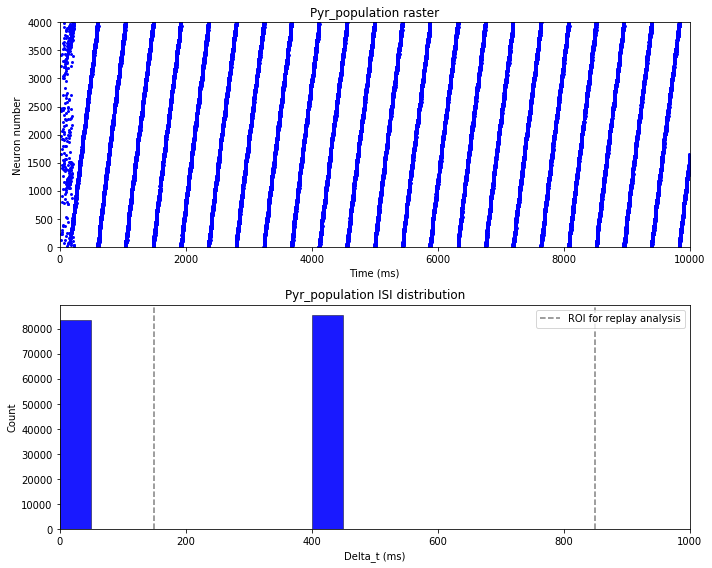

In [13]:
%matplotlib inline
if sme.num_spikes > 0 and smi.num_spikes > 0:  # check if there is any activity
    # Raster + ISI plot
    spikeTimesE, spikingNeuronsE, poprE, ISI = preprocess_spikes(sme.spike_trains(), NE)
    ISI = plot_raster_ISI(spikeTimesE, spikingNeuronsE, ISI, "blue", multiplier_=1)

    spikeTimesI, spikingNeuronsI, poprI = preprocess_spikes(smi.spike_trains(), NI, calc_ISI=False)

    # calling detect_oscillation functions:
    avgReplayInterval = replay(ISI[3:16])  # bins from 150 to 850 (range of interest)

    meanEr, rEAC, maxEAC, tMaxEAC, maxEACR, tMaxEACR, fE, PxxE, avgRippleFE, ripplePE = ripple(poprE, 1000)
    avgGammaFE, gammaPE = gamma(fE, PxxE)
    meanIr, rIAC, maxIAC, tMaxIAC, maxIACR, tMaxIACR, fI, PxxI, avgRippleFI, ripplePI = ripple(poprI, 1000)
    avgGammaFI, gammaPI = gamma(fI, PxxI)

    # Print out some info
    print 'Mean excitatory rate: ', meanEr
    print 'Maximum exc. autocorrelation:', maxEAC, 'at', tMaxEAC, '[ms]'
    print 'Maximum exc. AC in ripple range:', maxEACR, 'at', tMaxEACR, '[ms]'
    print 'Mean inhibitory rate: ', meanIr
    print 'Maximum inh. autocorrelation:', maxIAC, 'at', tMaxIAC, '[ms]'
    print 'Maximum inh. AC in ripple range:', maxIACR, 'at', tMaxIACR, '[ms]'
    print ''
    print 'Average exc. ripple freq:', avgRippleFE
    print 'Exc. ripple power:', ripplePE
    print 'Average exc. gamma freq:', avgGammaFE
    print 'Exc. gamma power:', gammaPE
    print 'Average inh. ripple freq:', avgRippleFI
    print 'Inh. ripple power:', ripplePI
    print 'Average inh. gamma freq:', avgGammaFI
    print 'Inh. gamma power:', gammaPI
    print "--------------------------------------------------"

else:  # if there is no activity the auto-correlation function will throw an error!

    print "No activity !"
    print "--------------------------------------------------"


## Plots

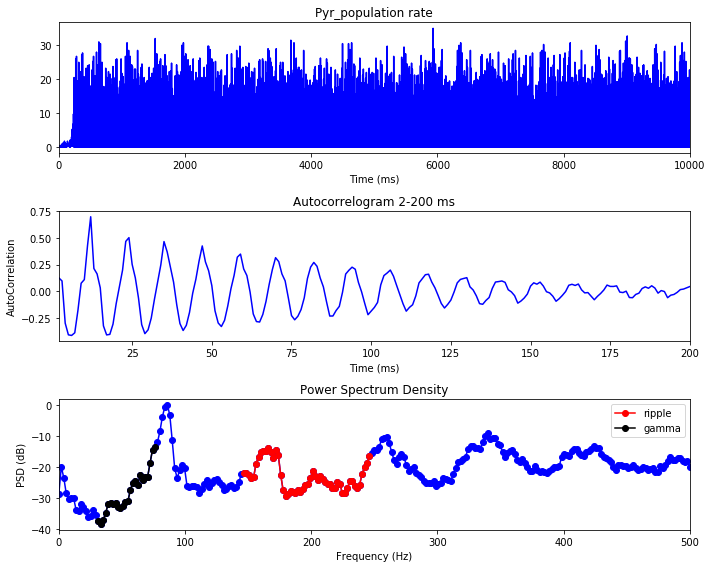

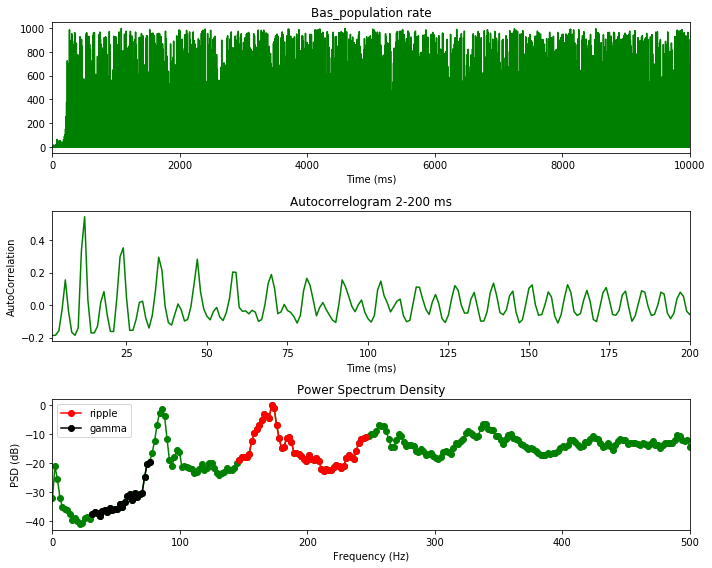

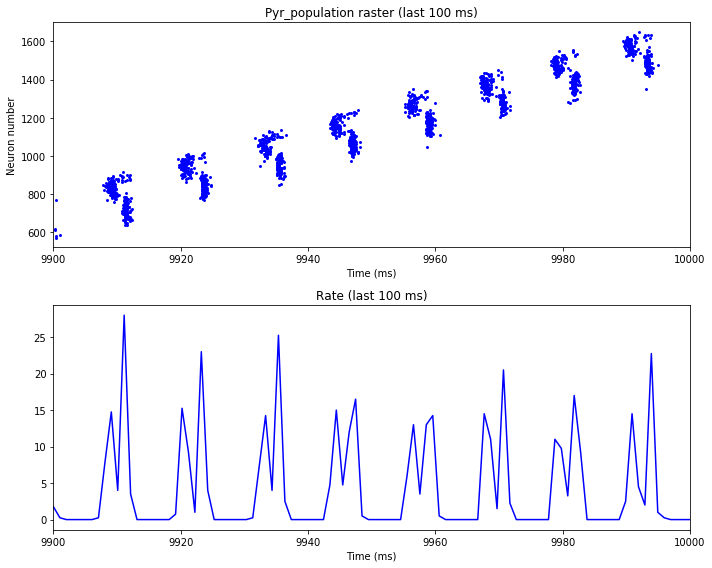

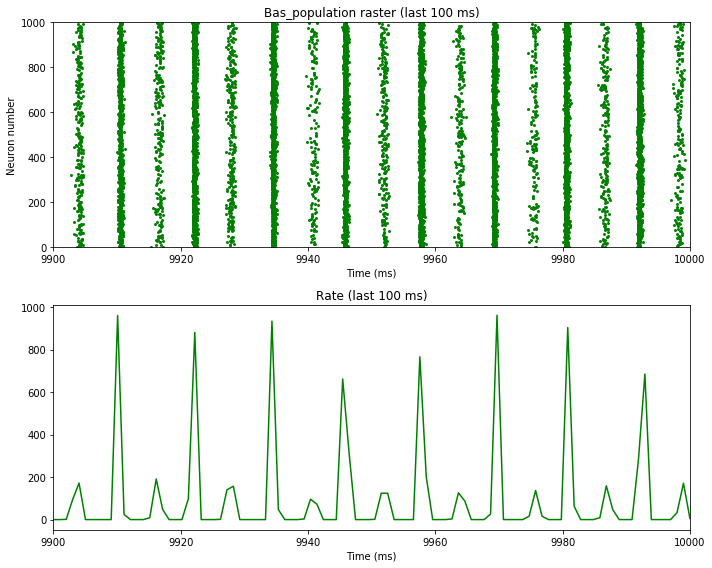

In [14]:
# Plots
if sme.num_spikes > 0 and smi.num_spikes > 0:    
    plot_PSD(poprE, rEAC, fE, PxxE, "Pyr_population", 'b-', multiplier_=1)
    plot_PSD(poprI, rIAC, fI, PxxI, "Bas_population", 'g-', multiplier_=1)

    ymin, ymax = plot_zoomed(spikeTimesE, spikingNeuronsE, poprE, "Pyr_population", "blue", multiplier_=1)
    plot_zoomed(spikeTimesI, spikingNeuronsI, poprI, "Bas_population", "green", multiplier_=1, Pyr_pop=False)
    #subset = select_subset(selection, ymin, ymax)
    #plot_detailed(msMe, subset, multiplier_=1)
    #plot_adaptation(msMe, selection, multiplier_=1)